<a href="https://colab.research.google.com/github/stinajoss/Bibliometri_GU/blob/main/OpenAlex_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API demo - Using Google Colab to retrieve and analyze API data

Google Colab notebooks enables you to write and execute Python code in your web browser.

You can use this notebook to retrieve data through the OpenAlex API and to analyze and visualize the data using Python code.

## 1. Retrieve works by entering id:s and publication years

To retrieve the relevant works, you need to iterate over multiple API result pages, since each API call returns at most 200 works. Each call yields a `results` object and a `meta` object. The `meta` object has a property `next_cursor`, which provides a reference to the next results page. The `next_cursor` references can be used to iterate over the result pages and to retrieve all results.

In [ ]:
import requests

# Enter ROR IDs (replace with your actual IDs
ror_ids = ["01tm6cn81"]  # Replace with your actual ROR Is or leave it empty if you don't want to search for ROR

# Enter author IDs (replace with your actual IDs, comma-separated for multiple)
author_ids = []  # Replace with your actual author ID or leave it empty if you don't want to search for authors

# Optional field ID (leave empty if not needed)
field_ids = ["14"]  # Replace with your actual field ID or leave it empty if you don't want to search for fields

# Enter start and end years
start_year = "2014"
end_year = "2023"

# Construct the filter string dynamically
filter_parts = [f"publication_year:{start_year}-{end_year}"]

# Add ROR filters if any ROR IDs are provided
if ror_ids:
    ror_filter = ";".join([f"authorships.institutions.ror:{id}" for id in ror_ids])
    filter_parts.append(ror_filter)

# Add author filters if any author IDs are provided
if author_ids:
    author_filter = ";".join([f"authorships.author.id:{id}" for id in author_ids])
    filter_parts.append(author_filter)

# Add field filters if provided
if field_ids:
    field_filter = ";".join([f"primary_topic.field.id:{id}" for id in field_ids])
    filter_parts.append(field_filter)

filter = ",".join(filter_parts)
api_url = f"https://api.openalex.org/works?filter={filter}&per-page=200"

cursor = "*"  # Cursor for the first request
works = []  # List to accumulate all results

while cursor:
    # Construct the request URL with the current cursor
    request_url = api_url + f"&cursor={cursor}"

    # Get results from the API
    page = requests.get(request_url).json()
    results = page.get('results') if page else None
    meta = page.get('meta') if page else None

    # Check if results is not None before trying to accumulate results
    if results is not None:
        works += results

    # Get the next cursor from the current results
    cursor = meta.get('next_cursor') if meta else None

    # Print progress
    total = int(meta.get("count")) if meta and meta.get("count") else 0
    print(f"\r{len(works)}/{total}: {request_url}", end="")

# Do something with all results
print(f"\nTotal works: {len(works)}")

1127/1127: https://api.openalex.org/works?filter=publication_year:2014-2023,authorships.institutions.ror:01tm6cn81,primary_topic.field.id:14&per-page=200&cursor=Ils2NC4wLCAwLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzQyMTQ3NjM1NDUnXSI=
Total works: 1127


##2. Export results as xlsx

In [ ]:
import pandas as pd

# Create a list of dictionaries with the extracted fields
data = []
for work in works:
    id = work.get('id').replace("https://openalex.org/", "")
    publication_year = work.get('publication_year')
    doi = work.get('doi')
    if doi:
        doi = doi.replace("https://doi.org/", "")
    else:
        doi = "N/A"  # Set a default value if 'doi' is None

    pubtype = work['type']

    # Check if 'title' exists and is not None
    if work.get('title'):
        title = work['title'][:99]
    else:
        title = "N/A"  # Set a default value if 'title' is None

    # Check if 'primary_location' exists and is not None
    if work.get('primary_location') and work['primary_location'].get('source'):
        source = work['primary_location']['source']['display_name']
    else:
        source = "N/A"  # Set a default value if 'primary_location' or 'source' is None

    is_oa = work['open_access']['is_oa']
    oa_status = work['open_access']['oa_status']
    oa_url = work['open_access']['oa_url']

    # Append the extracted fields to the list of dictionaries
    data.append({
        'id': id,
        'publication_year': publication_year,
        'doi': doi,
        'Publication_type': pubtype,
        'title': title,
        'source': source,
        'is_oa': is_oa,
        'oa_status': oa_status,
        'oa_url': oa_url
    })

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Specify the output file name (change as needed)
output_file = 'my_data_openalex_2014-2023.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_file, index=False)

print(f"DataFrame exported to {output_file}")

DataFrame exported to my_data_openalex_2014-2023.xlsx


## 3. List the 10 most highly cited works
    

A simple approach is to sort the list of works based on the `cited_by_count` key and to then take the first 10 works.

*Note: Sorting a list of dictionaries based on a key can be done by using the `sorted()` function in combination with a lambda (anonymous) function. The lambda function returns the relevant key for each work as it is being processed by the `sorted()` function.*

In [ ]:
import openpyxl  # Import the openpyxl library for XLSX file handling

# Sort the list of works based on the cited_by_count
works_cited = sorted(
    works,
    key=lambda work: work.get("cited_by_count"),
    reverse=True  # Reverse the sort to have the most cited works first
)

# Take the first 10 works from the sorted list
works_cited_top10 = works_cited[:10]

# Print the header
print(f"{'cited_by_count':<20} {'title':<100} {'source'} \n{'-' * 150}")
# Print the results
for work in works_cited_top10:
    cited_by_count = work['cited_by_count']
    title = work['title'][:99]
    source = work['primary_location']['source']['display_name']
    print(f"{cited_by_count:<20} {title:<100} {source}")

# Create a new workbook for xlsx export
wb = openpyxl.Workbook()
sheet = wb.active  # Get the active sheet

# Set column headers
sheet.cell(row=1, column=1).value = "Cited By Count"
sheet.cell(row=1, column=2).value = "Title"
sheet.cell(row=1, column=3).value = "Source"

# Start data rows from the second row
row_index = 2
for work in works_cited_top10:
    cited_by_count = work['cited_by_count']
    title = work['title'][:99]
    source = work['primary_location']['source']['display_name']

    sheet.cell(row=row_index, column=1).value = cited_by_count
    sheet.cell(row=row_index, column=2).value = title
    sheet.cell(row=row_index, column=3).value = source

    row_index += 1

# Save the workbook as a new XLSX file (replace 'top_cited_works.xlsx' with your desired filename)
wb.save('top_cited_works.xlsx')
print("Top cited works data saved to top_cited_works.xlsx!")


cited_by_count       title                                                                                                source 
------------------------------------------------------------------------------------------------------------------------------------------------------
680                  Cardiovascular Risk and Events in 17 Low-, Middle-, and High-Income Countries                        New England journal of medicine/The New England journal of medicine
392                  The digitalization of retailing: an exploratory framework                                            International journal of retail & distribution management
367                  From internationalization to evolution: The Uppsala model at 40 years                                Journal of international business studies
261                  Commitment to Sustainability in Small and Medium-Sized Enterprises: The Influence of Strategic Orie  Business strategy and the environment
189                  Ha

## 4. List the 25 sources with the largest number of works and display the number of citations and average number of citations per work

To aggregate over the results without using any complicated libraries we can construct a dictionary of sources.

For each source we collect the identifier, name, and initialize the number of works and citations to 0. This leaves us with a dictionary of unique sources.

In a next loop we can add the counts, by adding 1 to the relevant source for each work and adding the citations of that work to the total number of citations for the source.

*(These steps could be done in a single loop, but for simplicity we separate the two steps)*

Finally we calculate the average number of citations and sort the list.

In [ ]:
import openpyxl  # Import the openpyxl library for XLSX file handling


# Collect the sources
sources = {}
for work in works:
    if work["primary_location"] is not None:  # Check if primary_location is not None
        source = work["primary_location"]["source"]
        if source and source["id"]:  # Check if source and source ID exist
            sources[source["id"]] = {
                "id": source["id"].replace("https://openalex.org/", ""),
                "display_name": source["display_name"],
                "cited_by_count": 0,
                "works_count": 0
            }

# Count works and citations
for work in works:
    if work["primary_location"] is not None:  # Check if primary_location is not None
        source = work["primary_location"]["source"]
        if source and source["id"]:  # Check if source and source ID exist
            sources[source["id"]]["cited_by_count"] += work["cited_by_count"]
            sources[source["id"]]["works_count"] += 1

# Convert the dictionary into a list to make sorting easier
sources_list = sources.values()

# Calculate average number of citations for each source
for source in sources_list:
    source['cited_by_count_avg'] = round(source['cited_by_count'] / source['works_count'], 2)

# Sort the list of sources
sources_sorted = sorted(
    sources_list,
    key=lambda source: source["works_count"],
    reverse=True
)

# Take the first 25 source from the sorted list
sources_sorted_top25 = sources_sorted[:25]

# Print the list of sources
print(f"{'id':<15} {'source':<75} {'works_count':<15} {'cited_by_count':<15} {'avg_cited_by_count':<20} \n{'-' * 150}")
for source in sources_sorted_top25:
    id = source['id']
    works_count = source['works_count']
    cited_by_count = source['cited_by_count']
    cited_by_count_avg = source['cited_by_count_avg']
    name = source['display_name'][:74]
    print(f"{id:<15} {name:<75} {works_count:<15} {cited_by_count:<15} {cited_by_count_avg:<20}")

# Create a new workbook for xlsx export
wb = openpyxl.Workbook()
sheet = wb.active  # Get the active sheet

# Set column headers
sheet.cell(row=1, column=1).value = "ID"
sheet.cell(row=1, column=2).value = "Source Name"
sheet.cell(row=1, column=3).value = "Works Count"
sheet.cell(row=1, column=4).value = "Cited By Count"
sheet.cell(row=1, column=5).value = "Average Cited By Count"

# Start data rows from the second row
row_index = 2
for source in sources_sorted_top25:
    id = source['id']
    name = source['display_name'][:74]
    works_count = source['works_count']
    cited_by_count = source['cited_by_count']
    cited_by_count_avg = source['cited_by_count_avg']

    sheet.cell(row=row_index, column=1).value = id
    sheet.cell(row=row_index, column=2).value = name
    sheet.cell(row=row_index, column=3).value = works_count
    sheet.cell(row=row_index, column=4).value = cited_by_count
    sheet.cell(row=row_index, column=5).value = cited_by_count_avg

    row_index += 1

# Save the workbook as a new XLSX file (replace 'source_data.xlsx' with your desired filename)
wb.save('source_data.xlsx')
print("Source data saved to source_data.xlsx!")



id              source                                                                      works_count     cited_by_count  avg_cited_by_count   
------------------------------------------------------------------------------------------------------------------------------------------------------
S4210172589     Social Science Research Network                                             96              60              0.62                
S4306463937     Springer eBooks                                                             67              114             1.7                 
S4306463716     Palgrave Macmillan UK eBooks                                                20              5               0.25                
S130801046      The bulletin of symbolic logic/Bulletin of symbolic logic                 20              0               0.0                 
S171971387      Scandinavian journal of management                                          16              341            

## 5. List all OA colors with number of works and relative number of works

For each `oa_status` we count the number of works, calculate the counts relative to the total number, and show the results.

*Note: In the expression `oa[oa_status] = oa.get(oa_status, 0) + 1`, `oa.get(oa_status, 0)` evaluates to 0 if the current oa_status is not yet encountered in the list of works. This has the effect that the status will be added to the dictionary with a value of 1 if it is not yet present or incremented if it is already present.*

In [ ]:
# Collect and count the oa statuses
oa = {}
for work in works:
    oa_status = work.get("open_access").get("oa_status")
    oa[oa_status] = oa.get(oa_status, 0) + 1
# oa_list = {"hybrid": 5241, "gold": 33716, ...}

# Convert to a table
oa_list = oa.items()
# oa_list = [("hybrid", 5241), ("gold", 33716), ...]

# Sort the table
oa_sorted = sorted(
    oa_list,
    key=lambda oa: oa[1],  # sort the table by the second column
    reverse=True
)

# Print the sorted list
print(f"{'oa_status':<20} {'works_count':<20} {'works_count_relative':<20} \n{'-' * 100}")
for status, works_count in oa_sorted:
    relative = round(works_count / len(works) * 100, 2)
    print(f"{status:<20} {works_count:<20} {relative}")

oa_status            works_count          works_count_relative 
----------------------------------------------------------------------------------------------------
closed               609                  54.04
hybrid               240                  21.3
green                116                  10.29
gold                 83                   7.36
bronze               79                   7.01


## 6. Create a pie chart showing the OA colors

There are two main libraries used for plotting data in Python: Matplotlib and Plotly. Matplotlib is the most established and 'Pythonic' way to create plots. Plotly is a more modern approach with which it is easy to create interactive charts.

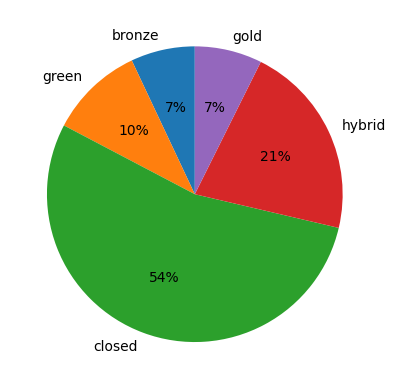

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

oa_names = oa.keys()     # ["hybrid", "gold", ...]
oa_counts = oa.values()  # [5241, 3716, ...]

plot_type = "Matplotlib" # @param ["Matplotlib", "Plotly"]
if plot_type == "Matplotlib":
    plt.pie(
        oa_counts,
        labels=oa_names,
        startangle=90,
        autopct='%1.0f%%'
    )
    plt.show()
else:
    fig = px.pie(
        names=oa_names,
        values=oa_counts
    )
    fig.show()


## 7. Create a line chart showing the total number of publications and citations per year

To create a line chart, we need two arrays, one for the x-axis and one for the y-axis. In this case we plot the publication years that we collect from the works on the x-axis and the counts on the y-axis.

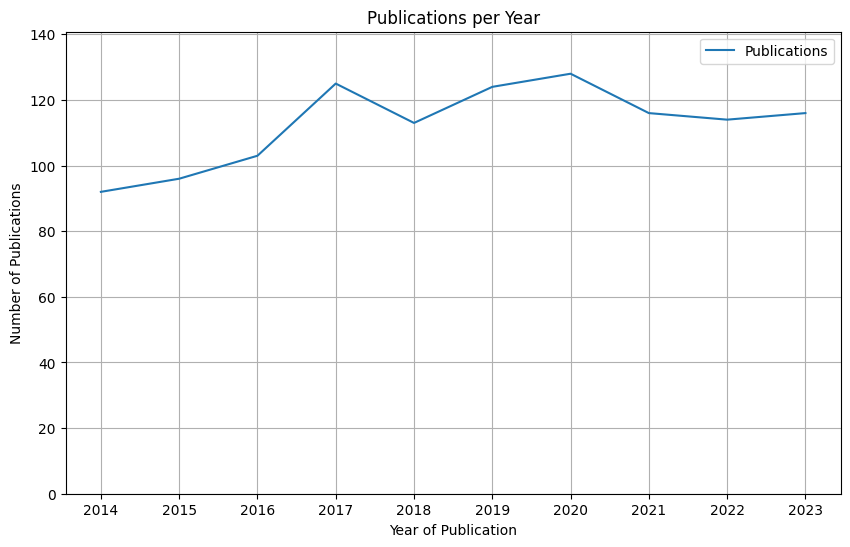

In [ ]:
import matplotlib.pyplot as plt  # Import for Matplotlib plots
import plotly.express as px  # Import for Plotly Express plots

year_works_count = {}
for work in works:
    year = str(work.get("publication_year"))  # Ensure year is a string
    year_works_count[year] = year_works_count.get(year, 0) + 1

# Convert to table
year_works_count_list = year_works_count.items()

# Sort the table by the first column
year_works_count_sorted = sorted(year_works_count_list, key=lambda year: year[0])

# Populate the x-axis
years = [year[0] for year in year_works_count_sorted]
# Populate the y-axis
publications = [year[1] for year in year_works_count_sorted]

plot_type = "Matplotlib"  # @param ["Matplotlib", "Plotly"]

if plot_type == "Matplotlib":
    plt.figure(figsize=(10, 6))  # Set a reasonable figure size for Matplotlib
    plt.plot(years, publications, label="Publications")  # Add label for the line
    plt.xlabel("Year of Publication")  # Set x-axis label
    plt.ylabel("Number of Publications")  # Set y-axis label
    plt.title("Publications per Year")  # Add title to the chart
    plt.ylim(0, max(publications) * 1.1)  # Set y-axis limits (similar to previous code)
    plt.legend()  # Show the legend
    plt.grid(True)  # Add grid lines for better readability
    plt.show()
else:
    fig = px.line(x=years, y=publications)  # Create Plotly Express figure
    fig.update_layout(
        title="Publications per Year",  # Add title to the chart
        xaxis_title="Year of Publication",  # Set x-axis label
        yaxis_title="Number of Publications",  # Set y-axis label
    )
    fig.update_traces(name="Publications")  # Add label for the line
    fig.show()


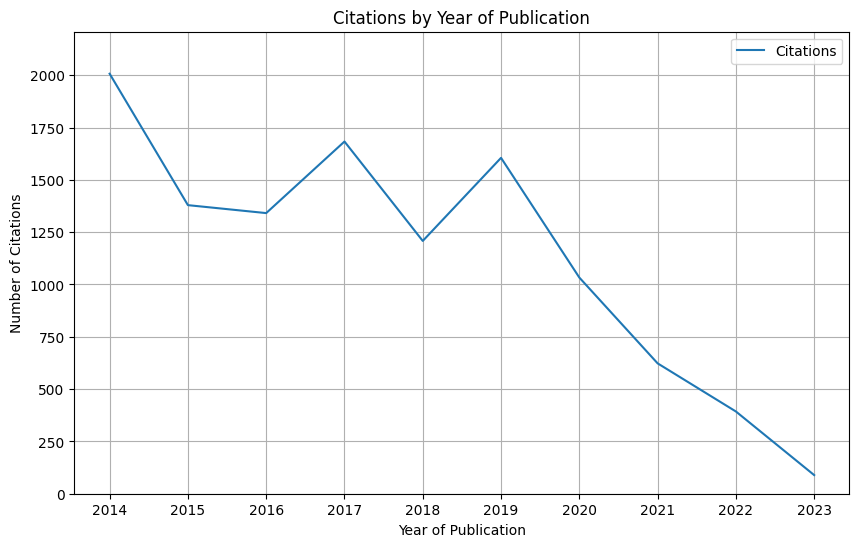

In [ ]:
import matplotlib.pyplot as plt  # Import for Matplotlib plots
import plotly.express as px  # Import for Plotly Express plots

year_cited_by_count = {}
for work in works:
    year = str(work.get("publication_year"))  # Ensure year is a string
    year_cited_by_count[year] = year_cited_by_count.get(year, 0) + work.get("cited_by_count", 0)

year_cited_by_count_list = year_cited_by_count.items()
year_cited_by_count_sorted = sorted(year_cited_by_count_list, key=lambda year: year[0])

years = [year[0] for year in year_cited_by_count_sorted]
citations = [year[1] for year in year_cited_by_count_sorted]

plot_type = "Matplotlib"  # @param ["Matplotlib", "Plotly"]

if plot_type == "Matplotlib":
    plt.figure(figsize=(10, 6))  # Set a reasonable figure size for Matplotlib
    plt.plot(years, citations, label="Citations")  # Add label for the line
    plt.xlabel("Year of Publication")  # Set x-axis label
    plt.ylabel("Number of Citations")  # Set y-axis label
    plt.title("Citations by Year of Publication")  # Add title to the chart
    plt.ylim(0, max(citations) * 1.1)  # Set y-axis limits (similar to previous code)
    plt.legend()  # Show the legend
    plt.grid(True)  # Add grid lines for better readability
    plt.show()
else:
    fig = px.line(x=years, y=citations)  # Create Plotly Express figure
    fig.update_layout(
        title="Citations by Year of Publication",  # Add title to the chart
        xaxis_title="Year of Publication",  # Set x-axis label
        yaxis_title="Number of Citations",  # Set y-axis label
    )
    fig.update_traces(name="Citations")  # Add label for the line
    fig.show()



## 8. Create a world map showing the number of authorships per country

To create a world map of the authorships per country, we can use a choropleth map using the Plotly library.

We can simply count the countries per authorship per work. But we need to sanitize the countries as OpenAlex provides ISO-2 country codes, while
Plotly expects ISO-3 country codes. We can use the `country_converter` library for this.

To create the choropleth map we need a geographic indicator, in this case a list of ISO-3 country codes, and a color indicator, in this case the authorship count per country. Optionally we can also include the full name of the countries as a label.

In [ ]:
%pip install country_converter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 742.6 kB/s eta 0:00:00


In [ ]:


# Count the countries per authorship per work
countries = {}
for work in works:
    for authorship in work.get("authorships"):
        for country in authorship.get("countries"):
            countries[country] = countries.get(country, 0) + 1

# If analyzing Swedish organization or author remove Sweden because swedish authorships will skew the data
remove_sweden = True # @param {type:"boolean"}
if remove_sweden:
    del countries["SE"]

import country_converter as coco
# Get the sanitized names from country_converer for the labels
countries_names = coco.convert([name for name in countries.keys()], to='name_short')
# Get ISO-3 codes from country_converer for the locations
countries_iso = coco.convert([name for name in countries.keys()], to='ISO3')
# Collect the counts for the colors on the map
countries_counts = [count for count in countries.values()]

fig = px.choropleth(
    hover_name=countries_names,
    locations=countries_iso,
    locationmode='ISO-3',
    color=countries_counts
)
fig.show()


<ipython-input-24-d1b42e11396e>:12: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



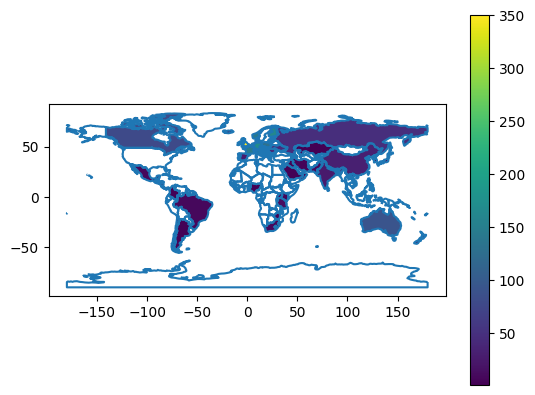

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Create a DataFrame from your data
df = pd.DataFrame({
    'country': countries_names,
    'count': countries_counts
})

# Load a GeoDataFrame with country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the GeoDataFrame
world = world.merge(df, left_on='name', right_on='country', how='left')

# Plot the data
fig, ax = plt.subplots(1, 1)
world.boundary.plot(ax=ax)
world.plot(column='count', ax=ax, legend=True)

# Save the figure as a JPEG image
plt.savefig('output.jpeg', format='jpeg')